# Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
from set_extraction_monks import x_train_m1, y_train_m1, x_test_m1, y_test_m1, x_train_m2, y_train_m2, x_test_m2, y_test_m2, x_train_m3, y_train_m3, x_test_m3, y_test_m3

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, data_5 to data_432
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   124 non-null    int64
 1   a1      124 non-null    int64
 2   a2      124 non-null    int64
 3   a3      124 non-null    int64
 4   a4      124 non-null    int64
 5   a5      124 non-null    int64
 6   a6      124 non-null    int64
dtypes: int64(7)
memory usage: 7.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, data_1 to data_432
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   432 non-null    int64
 1   a1      432 non-null    int64
 2   a2      432 non-null    int64
 3   a3      432 non-null    int64
 4   a4      432 non-null    int64
 5   a5      432 non-null    int64
 6   a6      432 non-null    int64
dtypes: int64(7)
memory usage: 27.0+ KB
Shapes before encoding:
x_train_m1 (124, 6)
y_train_m1 (124,)
x_test_m1 (

# Models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix, confusion_matrix

In [ ]:
%pip install pytorch-lightning

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from time import time
from torchmetrics import Accuracy, MeanSquaredError

In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
results = []

In [9]:
x_train_m1 = np.array(x_train_m1, dtype='float32')
y_train_m1 = np.array(y_train_m1, dtype='float32')
x_test_m1 = np.array(x_test_m1, dtype='float32')
y_test_m1 = np.array(y_test_m1, dtype='float32')

x_train_m2 = np.array(x_train_m2, dtype='float32')
y_train_m2 = np.array(y_train_m2, dtype='float32')
x_test_m2 = np.array(x_test_m2, dtype='float32')
y_test_m2 = np.array(y_test_m2, dtype='float32')

x_train_m3 = np.array(x_train_m3, dtype='float32')
y_train_m3 = np.array(y_train_m3, dtype='float32')
x_test_m3 = np.array(x_test_m3, dtype='float32')
y_test_m3 = np.array(y_test_m3, dtype='float32')

# Neural Networks

In [10]:
import itertools
from multiprocessing import Pool
from typing import Any, Optional
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold, StratifiedKFold
import torch.nn as nn

pl.seed_everything(42)

Global seed set to 42


42

In [11]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

In [12]:
# Define the MLP model
class MLP(pl.LightningModule):
    def __init__(self, in_dim, h_units, out_dim, activation, dropout_rate, num_hidden_layers, lr, momentum, weight_decay):
        super().__init__()

        self.layers = []
        self.acts = []
        self.drops = []

        layer = nn.Linear(in_dim, h_units)

        self.layers.append(layer) 
        self.acts.append(activation())
        if dropout_rate != 0:
            self.drops.append(nn.Dropout(dropout_rate))
            self.add_module(f"dro0", self.drops[-1])
        self.add_module(f"layer0", self.layers[-1])
        self.add_module(f"act0", self.acts[-1])
        

        for i in range(1, num_hidden_layers+1):
            h_units_out = h_units
            self.layers.append(nn.Linear(h_units, h_units_out))
            self.acts.append(activation())
            if dropout_rate != 0:
                self.drops.append(nn.Dropout(dropout_rate))
                self.add_module(f"dro{i}", self.drops[-1])
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.acts[-1])

        self.output = nn.Linear(h_units, out_dim)

        self.mse_loss = nn.MSELoss()
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def forward(self, x):

        if len(x.shape) == 1:
        # Handle single instance
            x = x.unsqueeze(0)  # Add an extra dimension for batch size
 
        if len(self.drops) > 0:
            for layer, act, dro in zip(self.layers, self.acts, self.drops):
                x = act(layer(x))
                x = dro(x)
        else:
            for layer, act in zip(self.layers, self.acts):
                x = act(layer(x))
        x = self.output(x) 
        x = nn.functional.sigmoid(x)

        return x 

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.reshape(-1, 1)
        loss = self.mse_loss(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.reshape(-1, 1)
        loss = self.mse_loss(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

In [13]:
# Define the callback to track the metrics
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.training_acc = []
        self.validation_acc = []
        self.training_loss = []
        self.validation_loss = []
        
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []

    def on_validation_end(self, trainer, pl_module):
        self.validation_acc.append(trainer.callback_metrics['val_acc'])
        self.validation_loss.append(trainer.callback_metrics['val_loss'])

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_loss_history.append(trainer.callback_metrics['val_loss'].item())
        self.val_acc_history.append(trainer.callback_metrics['val_acc'].item())

    def on_train_end(self, trainer, pl_module):
        print(trainer.callback_metrics)
        self.training_acc.append(trainer.callback_metrics['train_acc'])
        self.training_loss.append(trainer.callback_metrics['train_loss'])

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics['train_loss'].item())
        self.train_acc_history.append(trainer.callback_metrics['train_acc'].item())

In [14]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) 

In [15]:
def train_and_evaluate(params, x_train, y_train, dataset, param_grid):

    param_dict = dict(zip(param_grid.keys(), params))
    
    print(f"Testing parameter configuration: {param_dict}")
    
    kfold = StratifiedKFold(n_splits=5)
    mean_val_acc = []
    
    for fold, (train_indices, val_indices) in enumerate(kfold.split(torch.from_numpy(x_train).to(torch.float32), 
                                                                    torch.from_numpy(y_train).to(torch.float32))):
        print(f"Fold: {fold+1}")
        
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=None, shuffle=True)
        
        model = MLP(in_dim=x_train.shape[1], out_dim=1, **param_dict)
        
        metrics_callback = MetricsCallback()
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=True, min_delta=0.0001)
        
        trainer = pl.Trainer(
            max_epochs=500, 
            callbacks=[metrics_callback, early_stopping], 
            enable_progress_bar=False
        )
        
        trainer.fit(model, train_loader, val_loader)
        
        mean_val_acc.append(metrics_callback.validation_acc[-1])
    
    mean_val_acc = np.mean(mean_val_acc)
    print(f"Mean validation accuracy: {mean_val_acc}")
    
    return param_dict, mean_val_acc

## Pytorch - monk 1

### Grid search for parameter setting 


In [16]:
# Define the dataset and dataloader
dataset = MyDataset(x_train_m1, y_train_m1)
dataloader = DataLoader(dataset, shuffle=True) 

param_grid = {
    'dropout_rate': [0],
    'num_hidden_layers': [0],
    'h_units': [8],
    'activation': [nn.ReLU],
    'lr': [0.1, 0.2, 0.3],
    'momentum': [0.1, 0.2, 0.3], 
    'weight_decay': [0], 
}

# Generate all possible combinations of hyperparameters
param_combinations = itertools.product(*param_grid.values())

# Map the train_and_evaluate function to the parameter combinations
res = [train_and_evaluate(params, x_train_m1, y_train_m1, dataset, param_grid) for params in param_combinations]

# Process the results
mean_val_acc_config = []
configs = []

for param_dict, mean_val_acc in res:
    mean_val_acc_config.append(mean_val_acc)
    configs.append(param_dict)

print(f"\nThe best configuration is {configs[np.argmax(mean_val_acc_config)]} with a mean validation accuracy of {np.max(mean_val_acc_config)}")

Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 8, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.1, 'momentum': 0.1, 'weight_decay': 0}
Fold: 1
{'val_loss': tensor(0.0007), 'val_acc': tensor(1.), 'train_loss': tensor(0.0004), 'train_acc': tensor(1.)}
Fold: 2
{'val_loss': tensor(0.0013), 'val_acc': tensor(1.), 'train_loss': tensor(8.2611e-05), 'train_acc': tensor(1.)}
Fold: 3
{'val_loss': tensor(0.0044), 'val_acc': tensor(1.), 'train_loss': tensor(0.0001), 'train_acc': tensor(1.)}
Fold: 4
{'val_loss': tensor(0.0006), 'val_acc': tensor(1.), 'train_loss': tensor(0.0001), 'train_acc': tensor(1.)}
Fold: 5
{'val_loss': tensor(0.0006), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Mean validation accuracy: 1.0
Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 8, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.1, 'momentum': 0.2, 'weight_decay': 0}

In [17]:
# Final retraining -------------------------------------------------------------------------

In [18]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m1, x_val_m1, y_train_m1, y_val_m1 = train_test_split(x_train_m1, y_train_m1, test_size=0.2, shuffle=True, 
                                                              stratify=y_train_m1)

train_dataset = MyDataset(x_train_m1, y_train_m1)
val_dataset = MyDataset(x_val_m1, y_val_m1)
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=True)

for i in range(1,6):

    print("Trial", i)
    
    # Initialize the model
    model = MLP(in_dim=x_train_m1.shape[1], out_dim=1, **configs[np.argmax(mean_val_acc_config)])  

    # Initialize the trainer and callbacks
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=True, min_delta=0.0001)

    trainer = pl.Trainer(
        max_epochs=500, 
        callbacks=[metrics_callback, early_stopping], 
        enable_progress_bar=False, 
        )

    # Train the model
    trainer.fit(model, train_loader, val_loader)  

    models_train_mse.append(metrics_callback.train_loss_history)
    models_val_mse.append(metrics_callback.val_loss_history)
    models_train_acc.append(metrics_callback.train_acc_history)
    models_val_acc.append(metrics_callback.val_acc_history)

    final_models.append(model)

Trial 1
{'val_loss': tensor(0.0013), 'val_acc': tensor(1.), 'train_loss': tensor(8.7915e-05), 'train_acc': tensor(1.)}
Trial 2
{'val_loss': tensor(0.0193), 'val_acc': tensor(0.9600), 'train_loss': tensor(5.2390e-05), 'train_acc': tensor(1.)}
Trial 3
{'val_loss': tensor(0.0017), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Trial 4
{'val_loss': tensor(0.1361), 'val_acc': tensor(0.8000), 'train_loss': tensor(0.0117), 'train_acc': tensor(0.9899)}
Trial 5
{'val_loss': tensor(0.0010), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}


In [19]:
last = [el[-1] for el in models_val_mse]
last

[0.0012801267439499497,
 0.019336219877004623,
 0.0016561170341446996,
 0.13608327507972717,
 0.0009947819635272026]

In [20]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

2

In [21]:
models_val_acc[final_idx][-1]

1.0

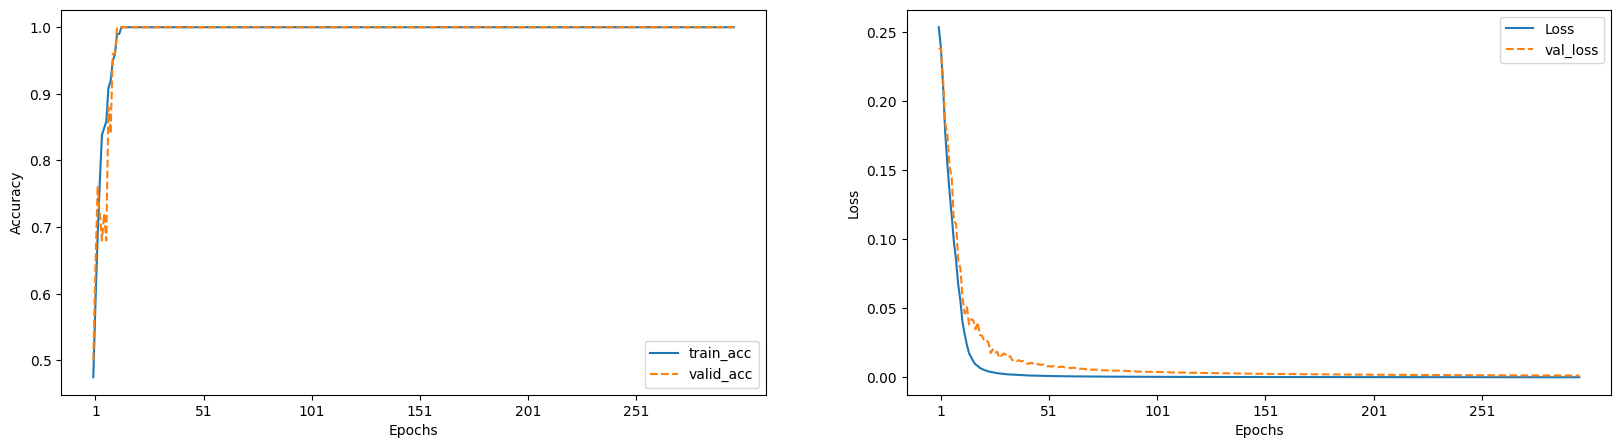

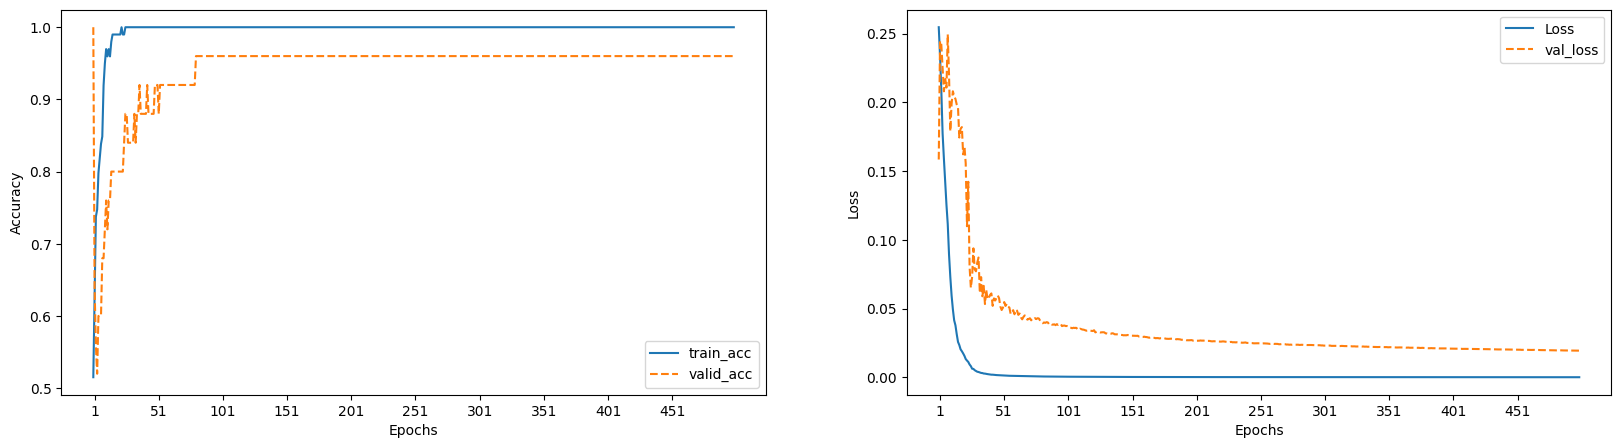

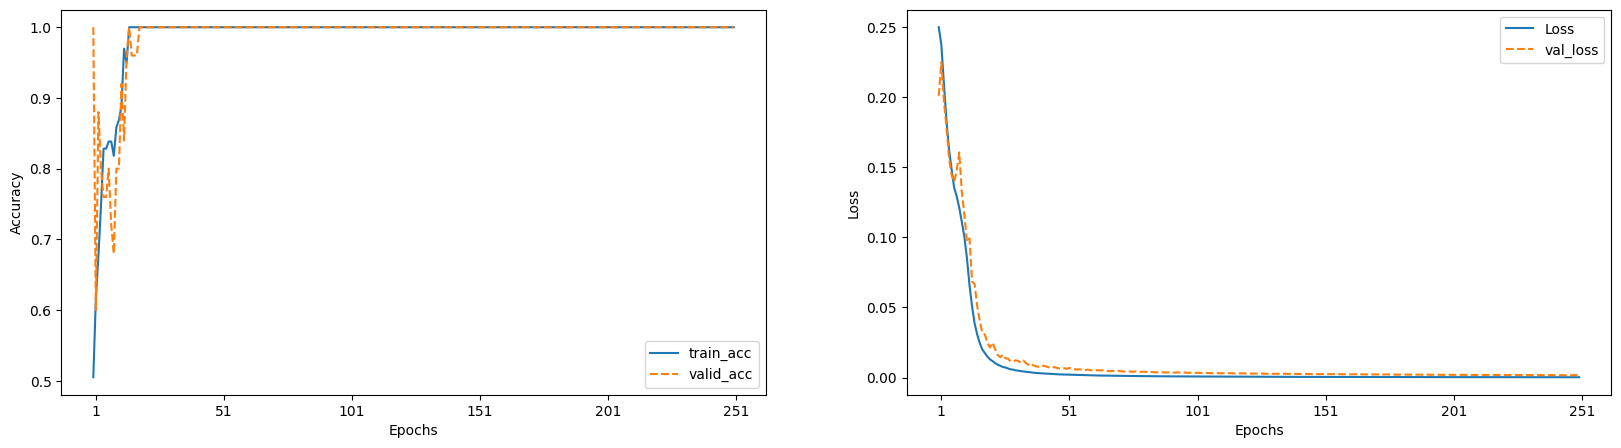

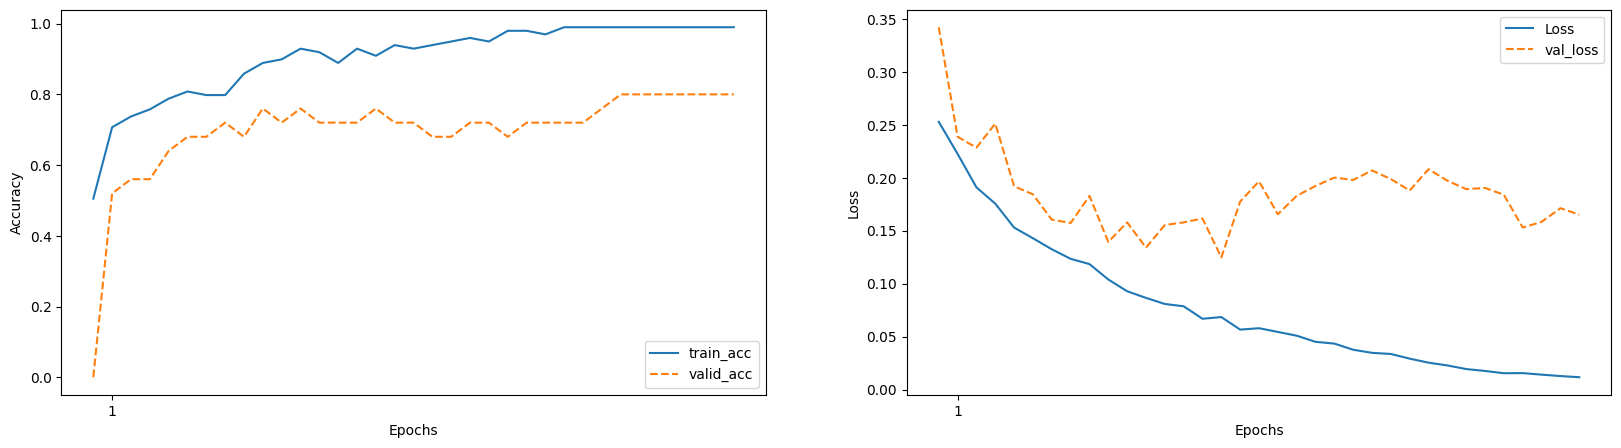

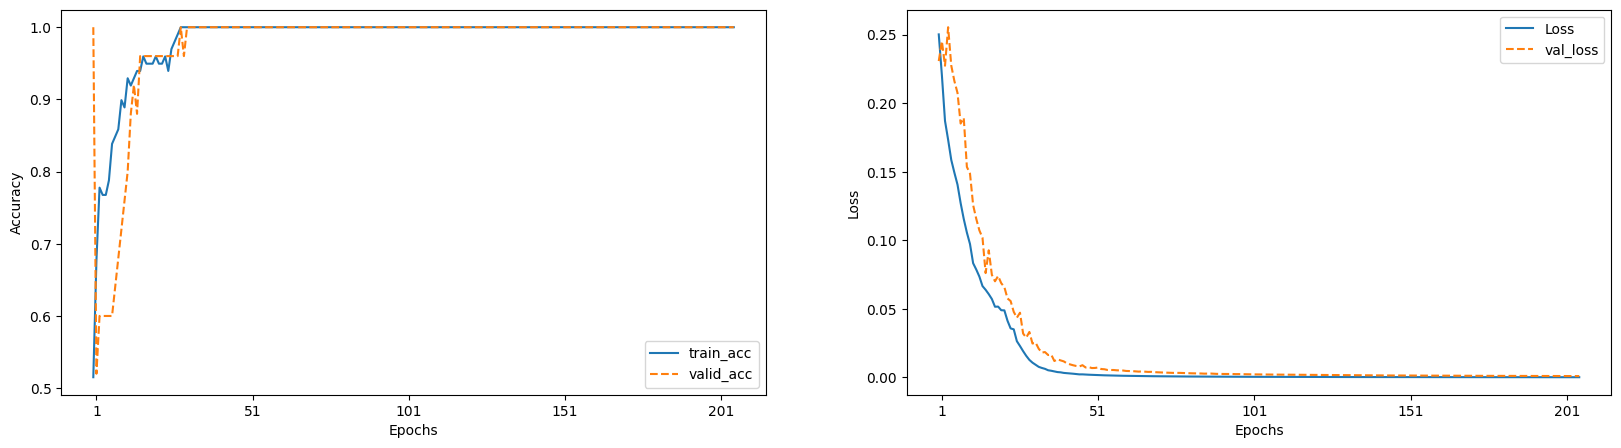

In [22]:
for i in range(5):

    b_ep = len(models_train_acc[i])

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    #accuracy plot
    axs[0].plot(models_train_acc[i][0:b_ep], label='train_acc') 
    axs[0].plot(models_val_acc[i][0:b_ep], label='valid_acc', linestyle='dashed')       
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
    axs[0].legend(loc = 'lower right')

    #Loss plot
    axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
    axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50) )
    axs[1].legend(loc = 'upper right')

    plt.show()

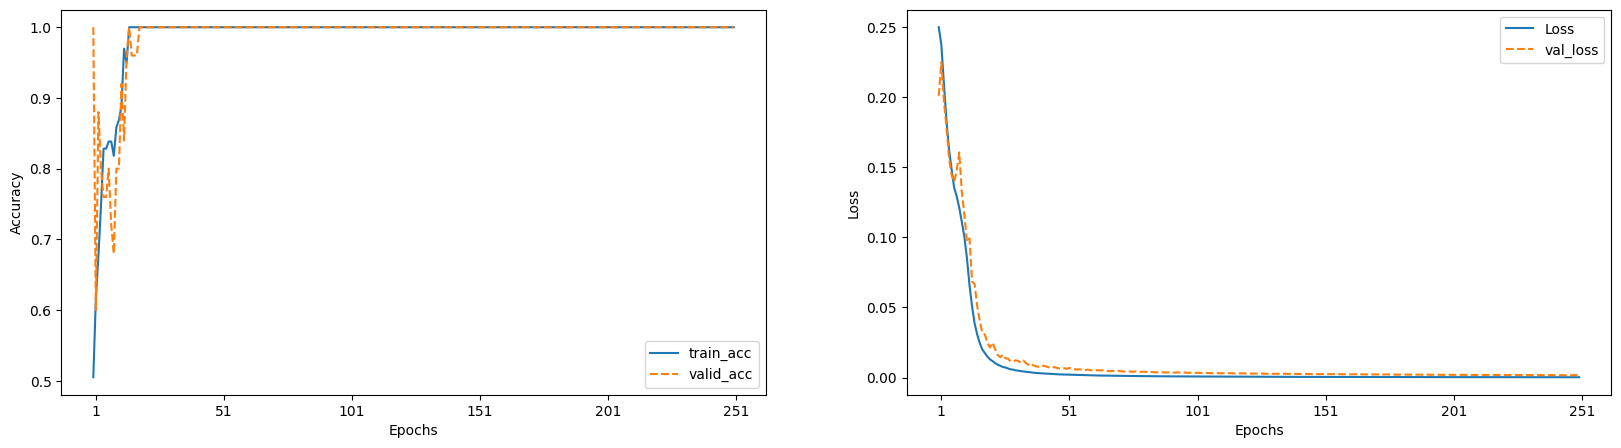

In [23]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='train_acc') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='valid_acc', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50)) 
axs[1].legend(loc = 'upper right')

plt.show()

In [24]:
results.append(('MLP pytorch-lightning monk-1 train', models_train_acc[final_idx][-1]))
results.append(('MLP pytorch-lightning monk-1 validation', models_val_acc[final_idx][-1]))
    
y_pred_m1 = model(torch.from_numpy(x_test_m1).to(torch.float32))

test_acc_m1 = model.train_acc(y_pred_m1, torch.from_numpy(y_test_m1).to(torch.float32).reshape(-1, 1))
results.append(('MLP pytorch-lightning monk-1 test', test_acc_m1))

In [25]:
print('MLP pytorch-lightning monk-1 train', models_train_acc[final_idx][-1])
print('MLP pytorch-lightning monk-1 validation', models_val_acc[final_idx][-1])
print('MLP pytorch-lightning monk-1 test', test_acc_m1)

MLP pytorch-lightning monk-1 train 1.0
MLP pytorch-lightning monk-1 validation 1.0
MLP pytorch-lightning monk-1 test tensor(1.)


In [26]:
joblib.dump(final_models[final_idx], 'monk_models/pytorch_median_m1.z')

['monk_models/pytorch_median_m1.z']

In [27]:
# --------------------------------------------------------------------------------------------

### Final model

In [112]:
pytorch = joblib.load('monk_models/pytorch_median_m1.z')

In [113]:
pytorch

MLP(
  (layer0): Linear(in_features=17, out_features=8, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [114]:
pytorch.eval()

MLP(
  (layer0): Linear(in_features=17, out_features=8, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [115]:
train_set_m1 = MyDataset(x_train_m1, y_train_m1)
# Make predictions on the train dataset
train_pred_pytorch = []
for batch in train_set_m1:
    inputs, targets = batch
    train_pred_pytorch.append(pytorch(inputs))

print("Train MSE monk-1 ", pytorch.mse_loss(torch.cat(train_pred_pytorch, dim=0), 
                                            torch.from_numpy(y_train_m1).to(torch.float32).reshape(-1, 1)).item())

test_set_m1 = MyDataset(x_test_m1, y_test_m1)
# Make predictions on the test dataset
test_pred_pytorch = []
for batch in test_set_m1:
    inputs, targets = batch
    test_pred_pytorch.append(pytorch(inputs))

print("Test MSE monk-1 ", pytorch.mse_loss(torch.cat(test_pred_pytorch, dim=0),
                                           torch.from_numpy(y_test_m1).to(torch.float32).reshape(-1, 1)).item())

Train MSE monk-1  0.0005144420429132879
Test MSE monk-1  0.00269974279217422


In [43]:
test_pred_pytorch = torch.cat(test_pred_pytorch, dim=0).detach().numpy()
test_pred_pytorch = np.round(test_pred_pytorch).astype('int64')

In [34]:
print('Accuarcy test set')
print(classification_report(y_test_m1, test_pred_pytorch))

Accuarcy test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       216
         1.0       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



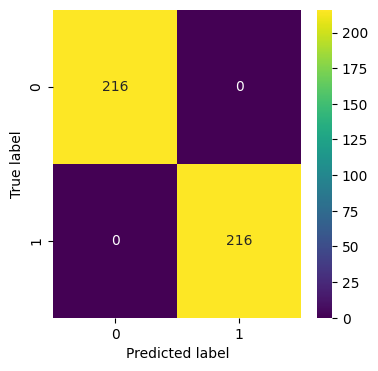

In [35]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_m1, test_pred_pytorch)
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Pytorch - monk 2

In [36]:
# Define the dataset and dataloader
dataset = MyDataset(x_train_m2, y_train_m2)
dataloader = DataLoader(dataset, shuffle=True) 

param_grid = {
    'dropout_rate': [0],
    'num_hidden_layers': [0],
    'h_units': [8],
    'activation': [nn.ReLU],
    'lr': [0.1, 0.3, 0.5, 0.7],
    'momentum': [0.1, 0.3, 0.5, 0.7], 
    'weight_decay': [0], 
}

# Generate all possible combinations of hyperparameters
param_combinations = itertools.product(*param_grid.values())

# Map the train_and_evaluate function to the parameter combinations
res = [train_and_evaluate(params, x_train_m2, y_train_m2, dataset, param_grid) for params in param_combinations]

# Process the results
mean_val_acc_config = []
configs = []

for param_dict, mean_val_acc in res:
    mean_val_acc_config.append(mean_val_acc)
    configs.append(param_dict)

print(f"\nThe best configuration is {configs[np.argmax(mean_val_acc_config)]} with a mean validation accuracy of {np.max(mean_val_acc_config)}")

Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 8, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.1, 'momentum': 0.1, 'weight_decay': 0}
Fold: 1
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Fold: 2
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Fold: 3
{'val_loss': tensor(0.0002), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Fold: 4
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Fold: 5
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Mean validation accuracy: 1.0
Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 8, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.1, 'momentum': 0.3, 'weight_decay': 0}
Fol

In [37]:
# Final retraining -------------------------------------------------------------------------

In [38]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m2, x_val_m2, y_train_m2, y_val_m2 = train_test_split(x_train_m2, y_train_m2, test_size=0.2, shuffle=True, 
                                                              stratify=y_train_m2)

train_dataset = MyDataset(x_train_m2, y_train_m2)
val_dataset = MyDataset(x_val_m2, y_val_m2)
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=True)

for i in range(1,6):

    print("Trial", i)
    
    # Initialize the model
    model = MLP(in_dim=x_train_m2.shape[1], out_dim=1, **configs[np.argmax(mean_val_acc_config)])  

    # Initialize the trainer and callbacks
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=True, min_delta=0.0001)

    trainer = pl.Trainer(
        max_epochs=500, 
        callbacks=[metrics_callback, early_stopping], 
        enable_progress_bar=False, 
        )

    # Train the model
    trainer.fit(model, train_loader, val_loader)  

    models_train_mse.append(metrics_callback.train_loss_history)
    models_val_mse.append(metrics_callback.val_loss_history)
    models_train_acc.append(metrics_callback.train_acc_history)
    models_val_acc.append(metrics_callback.val_acc_history)

    final_models.append(model)

Trial 1
{'val_loss': tensor(0.0002), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Trial 2
{'val_loss': tensor(0.0004), 'val_acc': tensor(1.), 'train_loss': tensor(0.0003), 'train_acc': tensor(1.)}
Trial 3
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Trial 4
{'val_loss': tensor(0.0003), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}
Trial 5
{'val_loss': tensor(0.0004), 'val_acc': tensor(1.), 'train_loss': tensor(0.0002), 'train_acc': tensor(1.)}


In [40]:
last = [el[-1] for el in models_val_mse]
last

[0.0002451337350066751,
 0.0004352395189926028,
 0.0002884882560465485,
 0.0002737094764597714,
 0.0004253068764228374]

In [41]:
# # median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

2

In [42]:
models_val_acc[final_idx][-1]

1.0

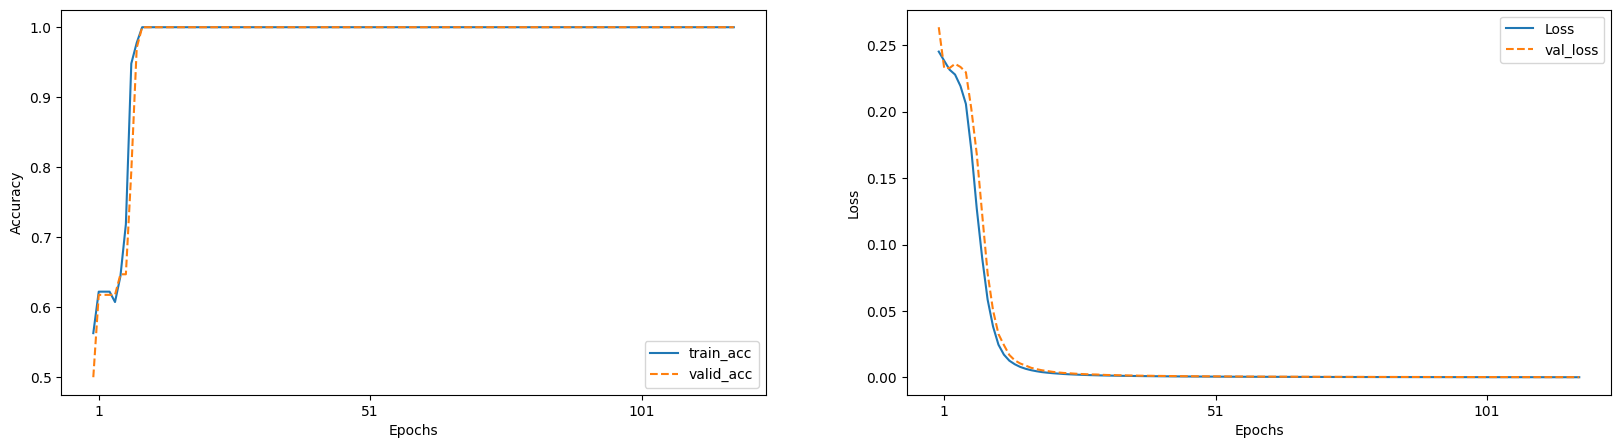

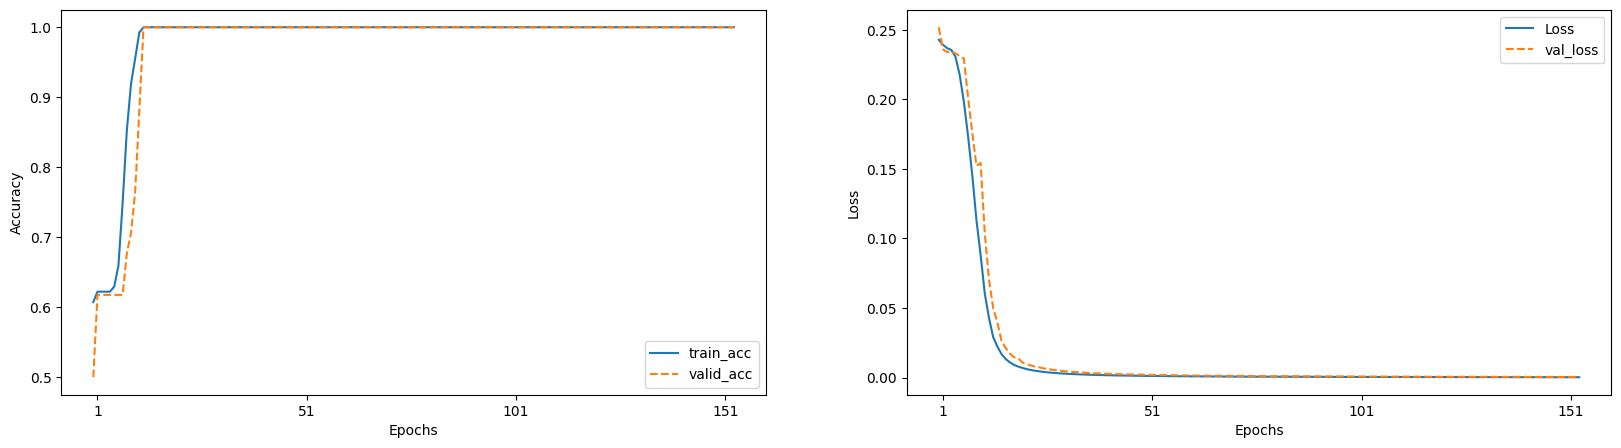

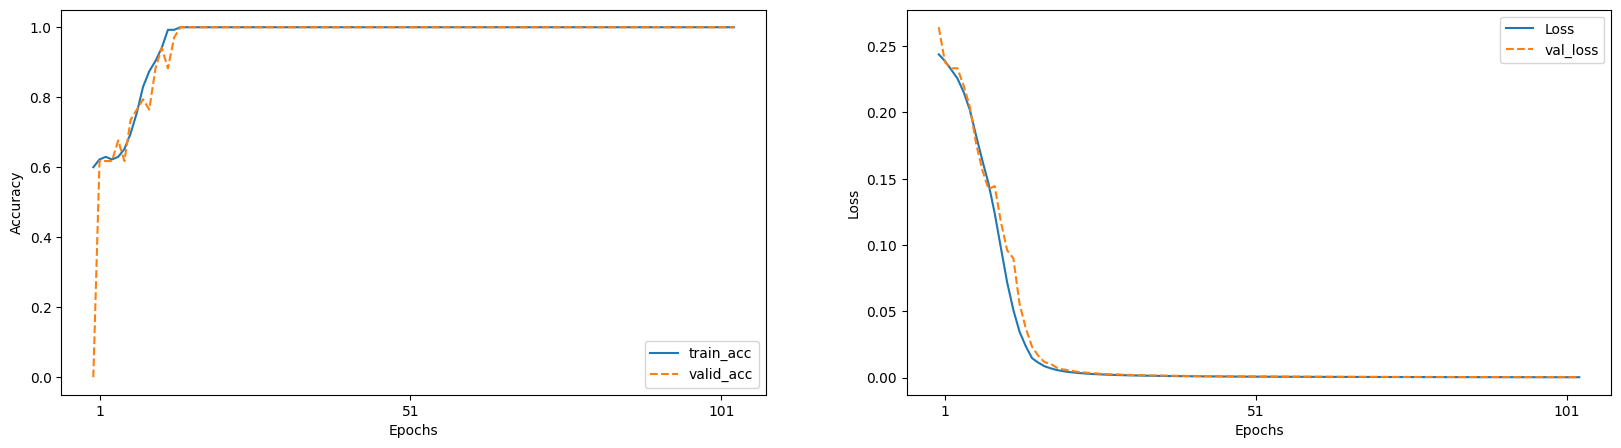

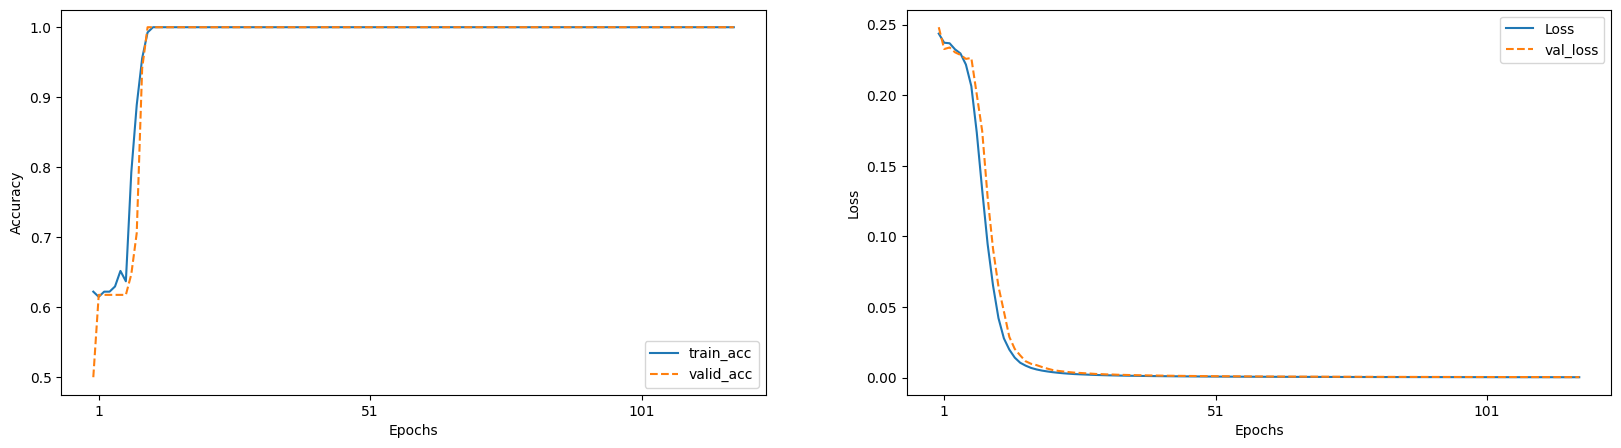

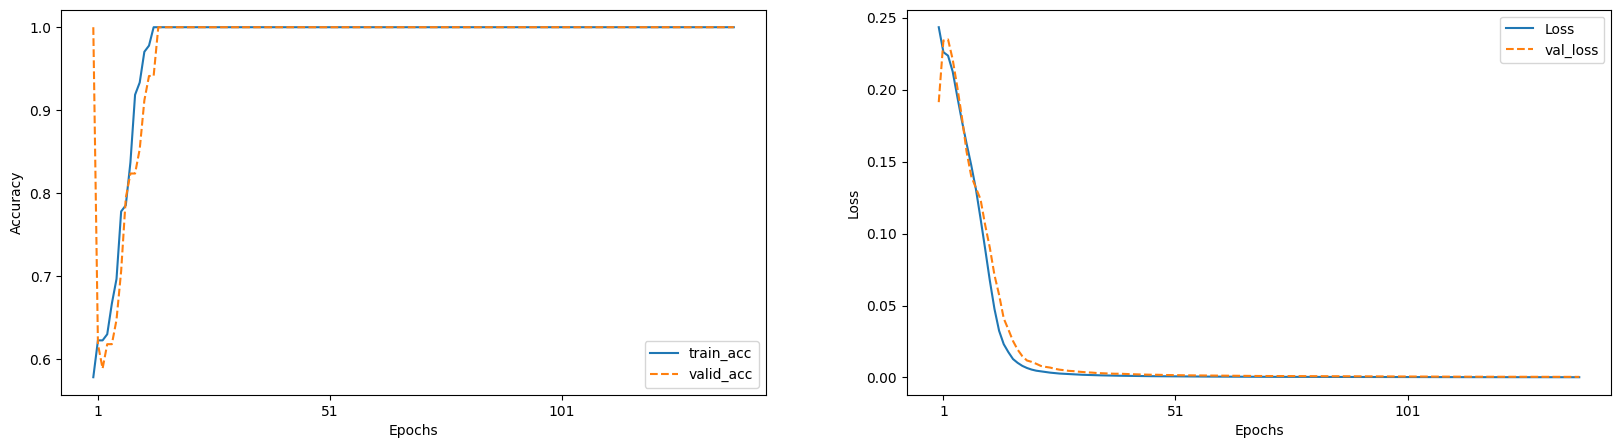

In [43]:
for i in range(5):

        b_ep = len(models_train_acc[i])

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        #accuracy plot
        axs[0].plot(models_train_acc[i][0:b_ep], label='train_acc') 
        axs[0].plot(models_val_acc[i][0:b_ep], label='valid_acc', linestyle='dashed')       
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
        axs[0].legend(loc = 'lower right')

        #Loss plot
        axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
        axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50) )
        axs[1].legend(loc = 'upper right')

        plt.show()

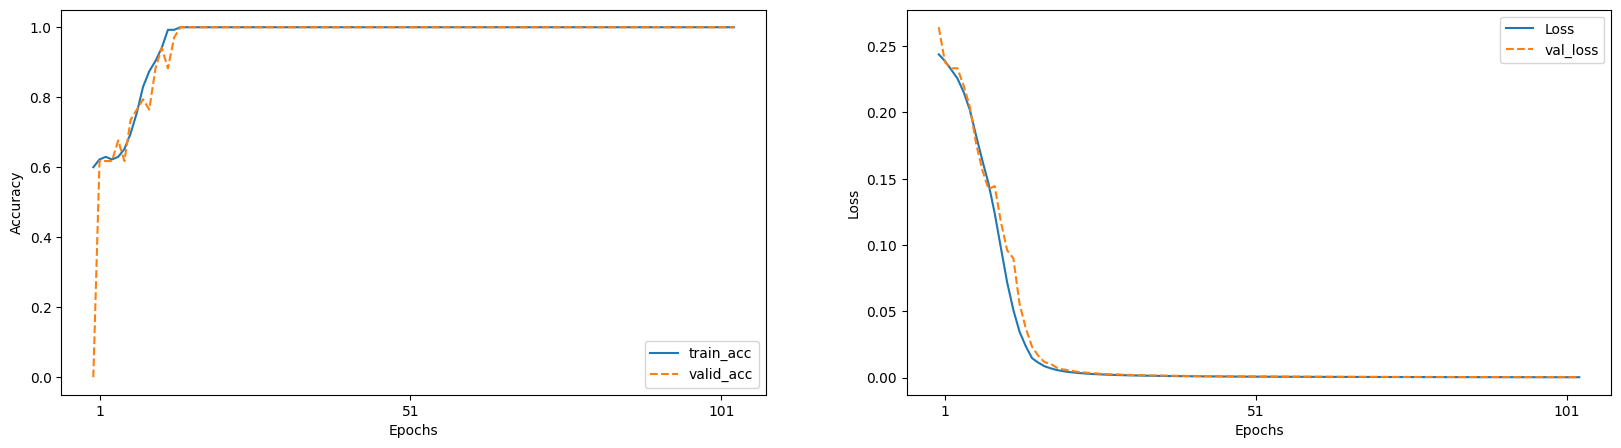

In [44]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='train_acc') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='valid_acc', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50)) 
axs[1].legend(loc = 'upper right')

plt.show()

In [45]:
results.append(('MLP pytorch-lightning monk-2 train', models_train_acc[final_idx][-1]))
results.append(('MLP pytorch-lightning monk-2 validation', models_val_acc[final_idx][-1]))
    
y_pred_m2 = model(torch.from_numpy(x_test_m2).to(torch.float32))

test_acc_m2 = model.train_acc(y_pred_m2, torch.from_numpy(y_test_m2).to(torch.float32).reshape(-1, 1))
results.append(('MLP pytorch-lightning monk-2 test', test_acc_m2))

In [46]:
print('MLP pytorch-lightning monk-2 train', models_train_acc[final_idx][-1])
print('MLP pytorch-lightning monk-2 validation', models_val_acc[final_idx][-1])
print('MLP pytorch-lightning monk-2 test', test_acc_m2)

MLP pytorch-lightning monk-2 train 1.0
MLP pytorch-lightning monk-2 validation 1.0
MLP pytorch-lightning monk-2 test tensor(1.)


In [47]:
joblib.dump(final_models[final_idx], 'monk_models/pytorch_median_m2.z')

['monk_models/pytorch_median_m2.z']

In [48]:
# --------------------------------------------------------------------------------------------

### Final model

In [104]:
pytorch = joblib.load('monk_models/pytorch_median_m2.z')

In [105]:
pytorch

MLP(
  (layer0): Linear(in_features=17, out_features=8, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [106]:
pytorch.eval()

MLP(
  (layer0): Linear(in_features=17, out_features=8, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [107]:
train_set_m2 = MyDataset(x_train_m2, y_train_m2)
# Make predictions on the train dataset
train_pred_pytorch = []
for batch in train_set_m2:
    inputs, targets = batch
    train_pred_pytorch.append(pytorch(inputs))

print("Train MSE monk-2 ", pytorch.mse_loss(torch.cat(train_pred_pytorch, dim=0), 
                                            torch.from_numpy(y_train_m2).to(torch.float32).reshape(-1, 1)).item())
test_set_m2 = MyDataset(x_test_m2, y_test_m2)
# Make predictions on the test dataset
test_pred_pytorch = []
for batch in test_set_m2:
    inputs, targets = batch
    test_pred_pytorch.append(pytorch(inputs))

print("Test MSE monk-2 ", pytorch.mse_loss(torch.cat(test_pred_pytorch, dim=0),
                                           torch.from_numpy(y_test_m2).to(torch.float32).reshape(-1, 1)).item())

Train MSE monk-2  0.0002450177271384746
Test MSE monk-2  0.0002697320596780628


In [54]:
test_pred_pytorch = torch.cat(test_pred_pytorch, dim=0).detach().numpy()
test_pred_pytorch = np.round(test_pred_pytorch).astype('int64')

In [55]:
print('Accuarcy test set')
print(classification_report(y_test_m2, test_pred_pytorch))

Accuarcy test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       290
         1.0       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



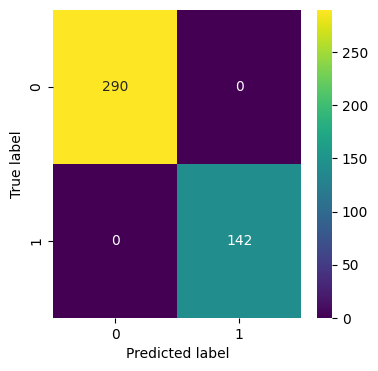

In [56]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_m2, test_pred_pytorch)
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Pytorch - monk 3

In [57]:
# Define the dataset and dataloader
dataset = MyDataset(x_train_m3, y_train_m3)
dataloader = DataLoader(dataset, shuffle=True) 

param_grid = {
    'dropout_rate': [0],
    'num_hidden_layers': [0],
    'h_units': [12],
    'activation': [nn.ReLU],
    'lr': [0.01, 0.1, 0.2],
    'momentum': [0.1, 0.3, 0.7],
    'weight_decay': [0.001, 0.01, 0.1], 
}

# Generate all possible combinations of hyperparameters
param_combinations = itertools.product(*param_grid.values())

# Map the train_and_evaluate function to the parameter combinations
res = [train_and_evaluate(params, x_train_m3, y_train_m3, dataset, param_grid) for params in param_combinations]

# Process the results
mean_val_acc_config = []
configs = []

for param_dict, mean_val_acc in res:
    mean_val_acc_config.append(mean_val_acc)
    configs.append(param_dict)

print(f"\nThe best configuration is {configs[np.argmax(mean_val_acc_config)]} with a mean validation accuracy of {np.max(mean_val_acc_config)}")

Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 12, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.01, 'momentum': 0.1, 'weight_decay': 0.001}
Fold: 1
{'val_loss': tensor(0.0611), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0345), 'train_acc': tensor(0.9794)}
Fold: 2
{'val_loss': tensor(0.0628), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0539), 'train_acc': tensor(0.9381)}
Fold: 3
{'val_loss': tensor(0.0708), 'val_acc': tensor(0.9167), 'train_loss': tensor(0.0327), 'train_acc': tensor(0.9490)}
Fold: 4
{'val_loss': tensor(0.0445), 'val_acc': tensor(0.9583), 'train_loss': tensor(0.0476), 'train_acc': tensor(0.9490)}
Fold: 5
{'val_loss': tensor(0.1059), 'val_acc': tensor(0.8750), 'train_loss': tensor(0.0420), 'train_acc': tensor(0.9490)}
Mean validation accuracy: 0.9340000152587891
Testing parameter configuration: {'dropout_rate': 0, 'num_hidden_layers': 0, 'h_units': 12, 'activation': <class 'torch.nn.modules.activat

In [58]:
# Final retraining -------------------------------------------------------------------------

In [59]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m3, x_val_m3, y_train_m3, y_val_m3 = train_test_split(x_train_m3, y_train_m3, test_size=0.2, shuffle=True, 
                                                              stratify=y_train_m3)

train_dataset = MyDataset(x_train_m3, y_train_m3)
val_dataset = MyDataset(x_val_m3, y_val_m3)
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=True)

for i in range(1,6):

    print("Trial", i)
    
    # Initialize the model
    model = MLP(in_dim=x_train_m3.shape[1], out_dim=1, **configs[np.argmax(mean_val_acc_config)])  

    # Initialize the trainer and callbacks
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=True, min_delta=0.0001)

    trainer = pl.Trainer(
        max_epochs=500, 
        callbacks=[metrics_callback, early_stopping], 
        enable_progress_bar=False, 
        )

    # Train the model
    trainer.fit(model, train_loader, val_loader)  

    models_train_mse.append(metrics_callback.train_loss_history)
    models_val_mse.append(metrics_callback.val_loss_history)
    models_train_acc.append(metrics_callback.train_acc_history)
    models_val_acc.append(metrics_callback.val_acc_history)

    final_models.append(model)

Trial 1
{'val_loss': tensor(0.0225), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0168), 'train_acc': tensor(0.9897)}
Trial 2
{'val_loss': tensor(0.0489), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0240), 'train_acc': tensor(0.9794)}
Trial 3
{'val_loss': tensor(0.0245), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0220), 'train_acc': tensor(0.9691)}
Trial 4
{'val_loss': tensor(0.0271), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0194), 'train_acc': tensor(0.9897)}
Trial 5
{'val_loss': tensor(0.0506), 'val_acc': tensor(0.9600), 'train_loss': tensor(0.0427), 'train_acc': tensor(0.9485)}


In [61]:
last = [el[-1] for el in models_val_mse]
last

[0.022541919723153114,
 0.04885243624448776,
 0.02451297454535961,
 0.027146633714437485,
 0.05056271702051163]

In [62]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

3

In [63]:
models_val_acc[final_idx][-1]

0.9599999785423279

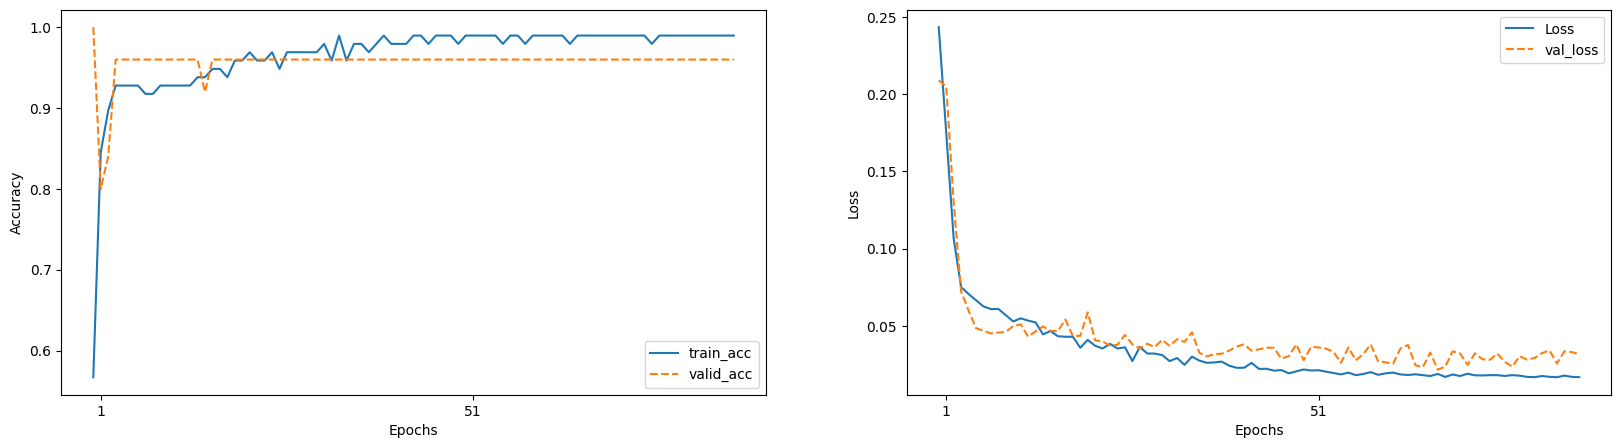

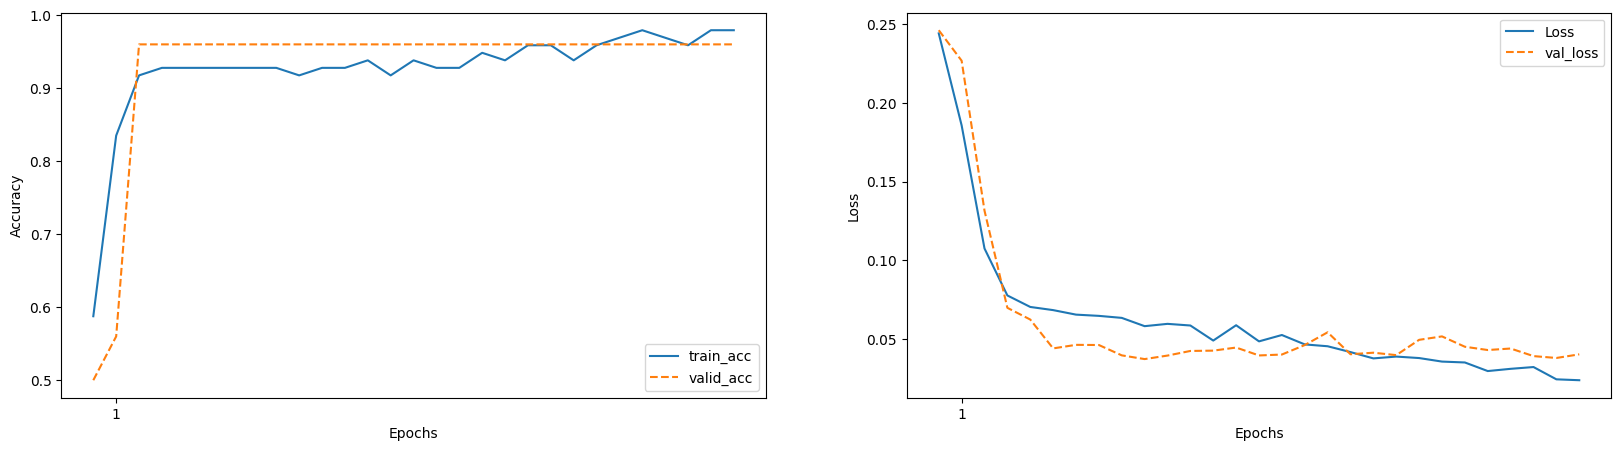

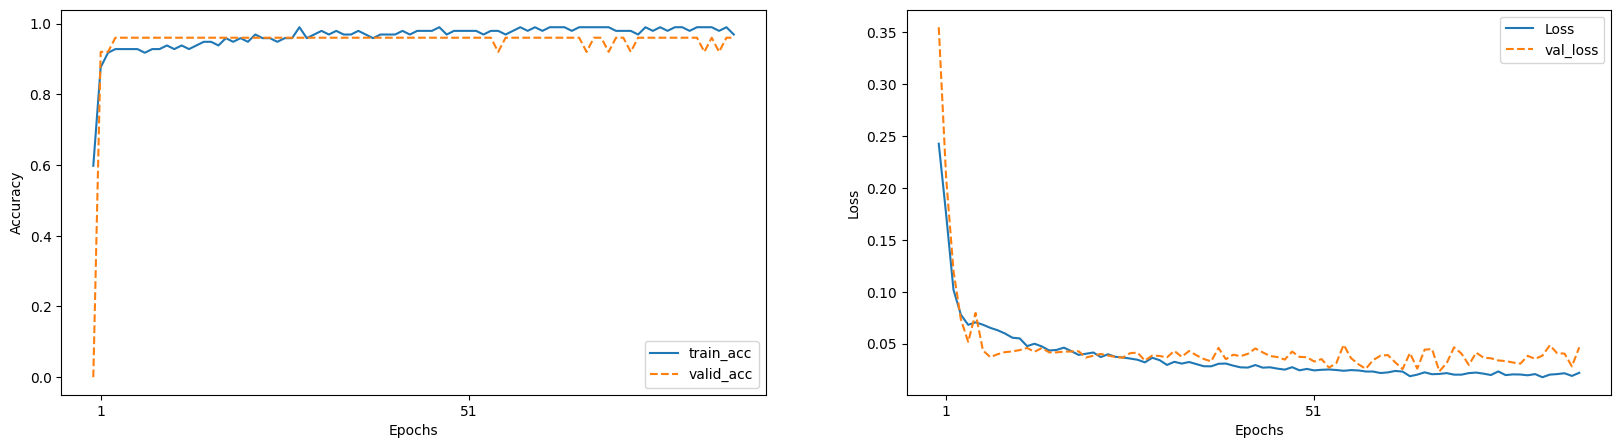

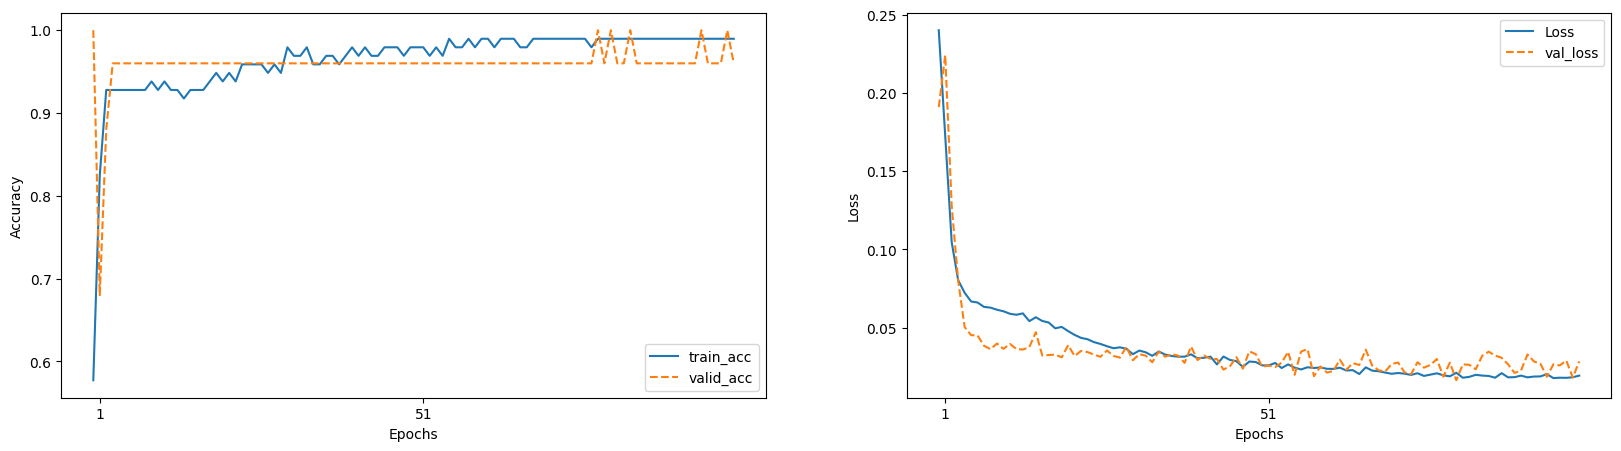

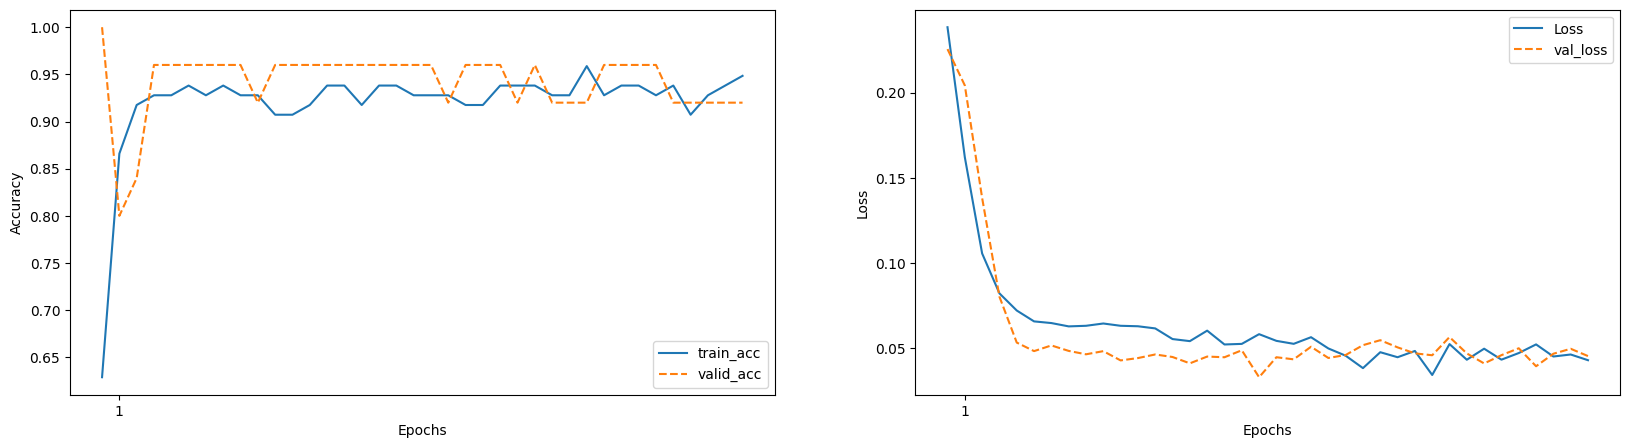

In [64]:
for i in range(5):

        b_ep = len(models_train_acc[i])

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        #accuracy plot
        axs[0].plot(models_train_acc[i][0:b_ep], label='train_acc') 
        axs[0].plot(models_val_acc[i][0:b_ep], label='valid_acc', linestyle='dashed')       
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
        axs[0].legend(loc = 'lower right')

        #Loss plot
        axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
        axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50) )
        axs[1].legend(loc = 'upper right')

        plt.show()

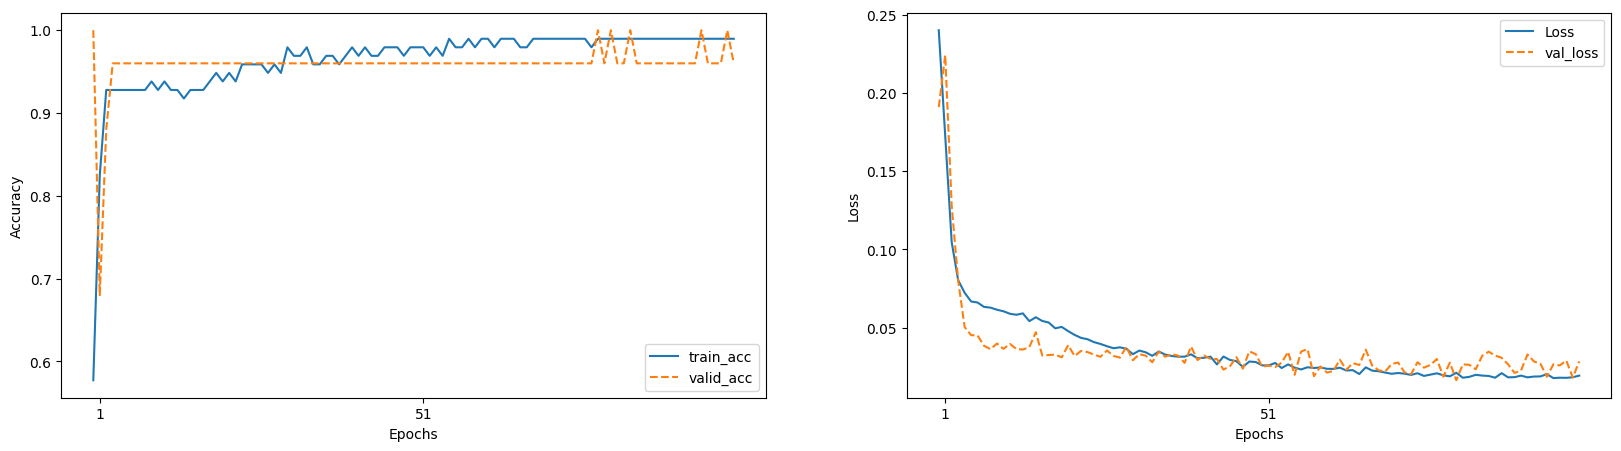

In [65]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='train_acc') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='valid_acc', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50)) 
axs[1].legend(loc = 'upper right')

plt.show()

In [66]:
results.append(('MLP pytorch-lightning monk-3 train', models_train_acc[final_idx][-1]))
results.append(('MLP pytorch-lightning monk-3 validation', models_val_acc[final_idx][-1]))
    
y_pred_m3 = model(torch.from_numpy(x_test_m3).to(torch.float32))

test_acc_m3 = model.train_acc(y_pred_m3, torch.from_numpy(y_test_m3).to(torch.float32).reshape(-1, 1))
results.append(('MLP pytorch-lightning monk-3 test', test_acc_m3))

In [67]:
print('MLP pytorch-lightning monk-3 train', models_train_acc[final_idx][-1])
print('MLP pytorch-lightning monk-3 validation', models_val_acc[final_idx][-1])
print('MLP pytorch-lightning monk-3 test', test_acc_m3)

MLP pytorch-lightning monk-3 train 0.9896907210350037
MLP pytorch-lightning monk-3 validation 0.9599999785423279
MLP pytorch-lightning monk-3 test tensor(0.9815)


In [68]:
joblib.dump(final_models[final_idx], 'monk_models/pytorch_median_m3.z')

['monk_models/pytorch_median_m3.z']

In [69]:
# --------------------------------------------------------------------------------------------

### Final model

In [108]:
pytorch = joblib.load('monk_models/pytorch_median_m3.z')

In [109]:
pytorch

MLP(
  (layer0): Linear(in_features=17, out_features=12, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=12, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [110]:
pytorch.eval()

MLP(
  (layer0): Linear(in_features=17, out_features=12, bias=True)
  (act0): ReLU()
  (output): Linear(in_features=12, out_features=1, bias=True)
  (mse_loss): MSELoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

In [111]:
train_set_m3 = MyDataset(x_train_m3, y_train_m3)
# Make predictions on the train dataset
train_pred_pytorch = []
for batch in train_set_m3:
    inputs, targets = batch
    train_pred_pytorch.append(pytorch(inputs))

print("Train MSE monk-3 ", pytorch.mse_loss(torch.cat(train_pred_pytorch, dim=0), 
                                            torch.from_numpy(y_train_m3).to(torch.float32).reshape(-1, 1)).item())
test_set_m3 = MyDataset(x_test_m3, y_test_m3)
# Make predictions on the test dataset
test_pred_pytorch = []
for batch in test_set_m3:
    inputs, targets = batch
    test_pred_pytorch.append(pytorch(inputs))

print("Test MSE monk-3 ", pytorch.mse_loss(torch.cat(test_pred_pytorch, dim=0),
                                           torch.from_numpy(y_test_m3).to(torch.float32).reshape(-1, 1)).item())

Train MSE monk-3  0.019112832844257355
Test MSE monk-3  0.02839348092675209


In [75]:
test_pred_pytorch = torch.cat(test_pred_pytorch, dim=0).detach().numpy()
test_pred_pytorch = np.round(test_pred_pytorch).astype('int64')

In [76]:
print('Accuarcy test set')
print(classification_report(y_test_m3, test_pred_pytorch))

Accuarcy test set
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       204
         1.0       1.00      0.96      0.98       228

    accuracy                           0.98       432
   macro avg       0.98      0.98      0.98       432
weighted avg       0.98      0.98      0.98       432



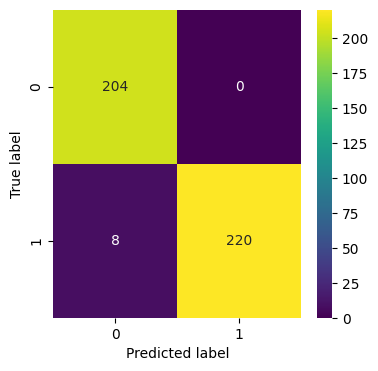

In [77]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_m3, test_pred_pytorch)
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Summary

In [78]:
for i in range(len(results)):
  print(results[i])

('MLP pytorch-lightning monk-1 train', 1.0)
('MLP pytorch-lightning monk-1 validation', 1.0)
('MLP pytorch-lightning monk-1 test', tensor(1.))
('MLP pytorch-lightning monk-2 train', 1.0)
('MLP pytorch-lightning monk-2 validation', 1.0)
('MLP pytorch-lightning monk-2 test', tensor(1.))
('MLP pytorch-lightning monk-3 train', 0.9896907210350037)
('MLP pytorch-lightning monk-3 validation', 0.9599999785423279)
('MLP pytorch-lightning monk-3 test', tensor(0.9815))
